In [5]:


import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import gym
import time
import mani_skill.env
import pandas as pd
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import style
from torch.distributions import Normal
import random
import time
use_cuda = torch.cuda.is_available()
device   = torch.device("cuda" if use_cuda else "cpu")

#####################  hyper parameters  ####################

MAX_EPISODES = 2001              
MAX_EP_STEPS = 60               

RENDER = False

LOAD_MEM = False
LOAD_MODEL = True
LOAD_FOLDER_NAME = 'carbinet_SELF_level_5_4000+2000EPS'

LOAD_PRETRAIN = False

CHECK_POINT_EPI = 50


ENV_NAME = 'OpenCabinetDrawer-v0'       
SEED = 123                      

var = 5
var_low_bound = 0.05



In [6]:
###############################  DDPG  ####################################
class DDPG(object):
    def __init__(self, a_dim, s_dim, a_bound,hidden_dim):
        self.a_dim = a_dim
        self.s_dim = s_dim
        self.a_bound = a_bound
        self.hidden_dim = hidden_dim
        self.pointer = 0                                                                         # exp buffer指针
        self.lr_a = 0.001                                                                      # learning rate for actor
        self.lr_c = 0.001                                                                       # learning rate for critic
        self.gamma = 0.9                                                                         # reward discount
        self.tau = 0.001                                                                          # 软更新比例
        self.memory_capacity = 10000
        self.batch_size = 32
        self.memory = np.zeros((self.memory_capacity, s_dim * 2 + a_dim + 1), dtype=np.float32)

        self.Reward_record = []
        self.Success_record = np.zeros(MAX_EPISODES)
        
        class ANet(nn.Module):                               # 定义动作网络
            def __init__(self, s_dim, a_dim, a_bound,hidden_size):
                super(ANet,self).__init__()
                self.a_bound = a_bound
                
                self.linear1 = nn.Linear(s_dim, hidden_size)
                self.linear2 = nn.Linear(hidden_size, hidden_size)
                self.linear3 = nn.Linear(hidden_size, hidden_size)
                self.linear4 = nn.Linear(hidden_size, a_dim)
                
                
                self.linear4.weight.data.uniform_(-0.03, 0.03)
                self.linear4.bias.data.uniform_(-0.03, 0.03)
#                 self.fc1 = nn.Linear(s_dim,256)
#                 self.fc1.weight.data.normal_(0,0.1)          # initialization
                
#                 self.fc2 = nn.Linear(256,512)
#                 self.fc2.weight.data.normal_(0,0.1)
#                                
#                 self.fc3 = nn.Linear(512,256)
#                 self.fc3.weight.data.normal_(0,0.1)
                
#                 self.out = nn.Linear(256,a_dim)
#                 self.out.weight.data.normal_(0,0.1)          # initialization
            def forward(self,x):
                x = F.relu(self.linear1(x))
                x = F.relu(self.linear2(x))
                x = F.relu(self.linear3(x))
                x = F.tanh(self.linear4(x))
                
#                 x = self.fc1(x)
#                 x = F.relu(x)
#                  
#                 x = self.fc2(x)
#                 x = F.relu(x)
                
#                 x = self.fc3(x)
#                 x = F.relu(x)
                
#                 x = self.out(x)
#                 x = F.tanh(x)
                actions_value = x * a_bound
                return actions_value

        class CNet(nn.Module):                               # 定义价值网络
            def __init__(self,s_dim,a_dim,hidden_size):
                super(CNet,self).__init__()
                
                self.linear1 = nn.Linear(s_dim + a_dim, hidden_size)
                self.linear2 = nn.Linear(hidden_size, hidden_size)
#                 self.linear3 = nn.Linear(hidden_size, hidden_size)
                self.linear3 = nn.Linear(hidden_size, 1)
                

                self.linear3.weight.data.uniform_(-0.03,0.03)
                self.linear3.bias.data.uniform_(-0.03,0.03)

#                 self.fcs1 = nn.Linear(s_dim,256)
#                 self.fcs1.weight.data.normal_(0,0.1)          # initialization
#                 #self.fcs1.weight.data.fill_(-0.01)
                
#                 self.fcs2 = nn.Linear(256,512)
#                 self.fcs2.weight.data.normal_(0,0.1)          # initialization
#                 #self.fcs1.weight.data.fill_(-0.01)
                
#                 self.fcs3 = nn.Linear(512,256)
#                 self.fcs3.weight.data.normal_(0,0.1)          # initialization
#                 #self.fcs1.weight.data.fill_(-0.01) 
                
#                 self.fca1 = nn.Linear(a_dim,256)
#                 self.fca1.weight.data.normal_(0,0.1)          # initialization
#                 #self.fcs1.weight.data.fill_(-0.01)
                
#                 self.fca2 = nn.Linear(256,512)
#                 self.fca2.weight.data.normal_(0,0.1)          # initialization
#                 #self.fcs1.weight.data.fill_(-0.01)              
                
#                 self.fca3 = nn.Linear(512,256)
#                 self.fca3.weight.data.normal_(0,0.1)          # initialization
#                 #self.fcs1.weight.data.fill_(-0.01)
                
#                 self.out = nn.Linear(256,1)
#                 self.out.weight.data.normal_(0,0.1)          # initialization
#                 #self.fcs1.weight.data.fill_(-0.01)
            def forward(self,s,a):
        
                x = torch.cat([s, a], 1)
                x = F.relu(self.linear1(x))
                x = F.relu(self.linear2(x))
#                 x = F.relu(self.linear3(x))
                x = self.linear3(x)

#                 x = self.fcs1(s)                              # 输入状态
#                 x = F.relu(x)
                
#                 x = self.fcs2(x)
#                 x = F.relu(x)
                
#                 x = self.fcs3(x)
#                 x = F.relu(x) 
                
#                 y = self.fca1(a)                              # 输入动作
#                 y = F.relu(y)
                
#                 y = self.fca2(y)                              
#                 y = F.relu(y)
                
#                 y = self.fca3(y)                              
#                 y = F.relu(y)
                
#                 net = F.relu(x+y)
#                 actions_value = self.out(net)                # 给出V(s,a)
                return x

        self.Actor_eval = ANet(s_dim, a_dim, a_bound, hidden_dim)        # 主网络
        self.Actor_target = ANet(s_dim, a_dim, a_bound, hidden_dim)      # 目标网络
        self.Critic_eval = CNet(s_dim, a_dim,hidden_dim)                # 主网络
        self.Critic_target = CNet(s_dim, a_dim,hidden_dim)              # 当前网络
        self.ctrain = torch.optim.Adam(self.Critic_eval.parameters(),lr = self.lr_c) # critic的优化器
        self.atrain = torch.optim.Adam(self.Actor_eval.parameters(),lr = self.lr_a)  # actor的优化器
        self.loss_td = nn.MSELoss()                          # 损失函数采用均方误差

    def choose_action(self, s):
        s = torch.unsqueeze(torch.FloatTensor(s), 0)

        return self.Actor_eval(s)[0].detach()                

    def learn(self):
        #self.atrain = torch.optim.Adam(self.Actor_eval.parameters(),lr = lr_a)  # actor的优化器
        #self.ctrain = torch.optim.Adam(self.Critic_eval.parameters(),lr = lr_c) # critic的优化器
        for x in self.Actor_target.state_dict().keys():#更新target network
            eval('self.Actor_target.' + x + '.data.mul_((1 - self.tau))')  
            eval('self.Actor_target.' + x + '.data.add_(self.tau * self.Actor_eval.' + x + '.data)')
        for x in self.Critic_target.state_dict().keys():
            eval('self.Critic_target.' + x + '.data.mul_((1- self.tau))')
            eval('self.Critic_target.' + x + '.data.add_(self.tau * self.Critic_eval.' + x + '.data)')

        # soft target replacement

        indices = np.random.choice(self.memory_capacity, size = self.batch_size)  # 随机采样的index
        bt = self.memory[indices, :]                                              # 采样batch_size个sample
        bs = torch.FloatTensor(bt[:, :self.s_dim])                                # state
        ba = torch.FloatTensor(bt[:, self.s_dim: self.s_dim + self.a_dim])        # action
        br = torch.FloatTensor(bt[:, -self.s_dim - 1: -self.s_dim])               # reward
        bs_ = torch.FloatTensor(bt[:, -self.s_dim:])                              # next state
        
        
        a = self.Actor_eval(bs)
        q = self.Critic_eval(bs,a)  

        loss_a = -torch.mean(q)            
        #print('q: ',q)
        #print('loss_a: ',loss_a)
        self.atrain.zero_grad()
        loss_a.backward()
        self.atrain.step()
        
        
        a_ = self.Actor_target(bs_)      
        q_ = self.Critic_target(bs_,a_)  
        q_target = br + self.gamma * q_  

        q_v = self.Critic_eval(bs,ba)

        td_error = self.loss_td(q_target,q_v)

        self.ctrain.zero_grad()
        td_error.backward()
        self.ctrain.step()
        
        
    def store_transition(self, s, a, r, s_):
        transition = np.hstack((s, a, [r], s_))
        index = self.pointer % self.memory_capacity     # replace the old memory with new memory
        self.memory[index, :] = transition
        self.pointer += 1                              
    
    def store_reward(self,ep_reward):
        self.Reward_record.append(ep_reward)
        
    def Record_success(self,epi):
        self.Success_record[epi] = 1
        
    def save(self,folder_name):
    
        if os.path.exists('./DPG model/' + folder_name):
            os.remove('./DPG model/' + folder_name)
            
        os.mkdir('./DPG model/' + folder_name)
    
        PATH1 = './DPG model/' + folder_name + '/Actor_eval.h5f'
        PATH2 = './DPG model/' + folder_name + '/Actor_target.h5f'
        PATH3 = './DPG model/' + folder_name + '/Critic_eval.h5f'
        PATH4 = './DPG model/' + folder_name + '/Critic_target.h5f'
    
        torch.save(self.Actor_eval.state_dict(), PATH1)
        torch.save(self.Actor_target.state_dict(), PATH2)
        torch.save(self.Critic_eval.state_dict(), PATH3)
        torch.save(self.Critic_target.state_dict(), PATH4)
    
        csv_name='./DPG model/' + folder_name + '/memory.csv'
        xml_df = pd.DataFrame(self.memory)
        xml_df.to_csv(csv_name, index = None, columns= None)
        
        csv_name='./DPG model/' + folder_name + '/Rewards.csv'
        xml_df = pd.DataFrame(self.Reward_record)
        xml_df.to_csv(csv_name, index = None, columns= None)
        
        csv_name='./DPG model/' + folder_name + '/Success_record.csv'
        xml_df = pd.DataFrame(self.Success_record)
        xml_df.to_csv(csv_name, index = None, columns= None)
        
        y = self.Reward_record
        x = range(len(y))
        plt.figure(figsize=(10, 10), dpi=70)
        plt.scatter(x, y)
        plt.savefig('./DPG model/' + folder_name + '/scatter.png')
        plt.plot(x, y)
        plt.savefig('./DPG model/' + folder_name + '/plot.png')
        
    def plot_file_rewards(self, folder_name):
        data = pd.read_csv('./DPG model/' + folder_name + '/Rewards.csv')
        y = np.array(data).squeeze()
        x = range(y.shape[0])
        plt.figure(figsize=(10, 10), dpi=70)
        #plt.plot(x, y)
        plt.scatter(x, y)
        plt.show()
    
    def plot_rewards(self, scatter):
        y = self.Reward_record
        x = range(len(y))
        plt.figure(figsize=(10, 10), dpi=70)
        
        if scatter:
            plt.scatter(x, y)
        else:
            plt.plot(x, y)
        plt.show()
    
    def load_model(self):
        self.Actor_eval.load_state_dict(torch.load('./DPG model/' + LOAD_FOLDER_NAME + '/Actor_eval.h5f'))
        self.Actor_eval.eval()
        self.Actor_target.load_state_dict(torch.load('./DPG model/' + LOAD_FOLDER_NAME + '/Actor_target.h5f'))
        self.Actor_target.eval()
        self.Critic_eval.load_state_dict(torch.load('./DPG model/' + LOAD_FOLDER_NAME + '/Critic_eval.h5f'))
        self.Critic_eval.eval()
        self.Critic_target.load_state_dict(torch.load('./DPG model/' + LOAD_FOLDER_NAME + '/Critic_target.h5f'))
        self.Critic_target.eval()
        print("Load network parameters of: " + LOAD_FOLDER_NAME) 
        
    def load_memory(self):
        data = pd.read_csv('./DPG model/' + LOAD_FOLDER_NAME + '/memory.csv')
        self.memory = np.array(data)
        print("Load memory of: " + LOAD_FOLDER_NAME)
        
    def load_pretrain(self):    
        ddpg.Actor_eval.load_state_dict(torch.load('./DPG model/pretrain/Actor_eval.h5f'))
        ddpg.Actor_eval.eval()
        ddpg.Actor_target.load_state_dict(torch.load('./DPG model/pretrain/Actor_eval.h5f'))
        ddpg.Actor_target.eval() 
#         ddpg.Critic_eval.load_state_dict(torch.load('./DPG model/pretrain/Critic_eval.h5f'))
#         ddpg.Critic_eval.eval()
#         ddpg.Critic_target.load_state_dict(torch.load('./DPG model/pretrain/Critic_eval.h5f'))
#         ddpg.Critic_target.eval() 

Load network parameters of: carbinet_SELF_level_5_4000+2000EPS
Episode: 0  Reward: -89 Explore: 0.05
SUCCESS
Episode: 1  Reward: 671 Explore: 0.05
SUCCESS
Episode: 2  Reward: 675 Explore: 0.05
SUCCESS
Episode: 3  Reward: 1362 Explore: 0.05
SUCCESS
Episode: 4  Reward: 560 Explore: 0.05
Episode: 5  Reward: 212 Explore: 0.05
Episode: 6  Reward: -76 Explore: 0.05
SUCCESS
Episode: 7  Reward: 854 Explore: 0.05
Episode: 8  Reward: -53 Explore: 0.05
Episode: 9  Reward: 113 Explore: 0.05
SUCCESS
Episode: 10  Reward: 1397 Explore: 0.05
SUCCESS
Episode: 11  Reward: 675 Explore: 0.05
SUCCESS
Episode: 12  Reward: 754 Explore: 0.05
Episode: 13  Reward: 33 Explore: 0.05
SUCCESS
Episode: 14  Reward: 836 Explore: 0.05
SUCCESS
Episode: 15  Reward: 996 Explore: 0.05
SUCCESS
Episode: 16  Reward: 652 Explore: 0.05
SUCCESS
Episode: 17  Reward: 560 Explore: 0.05
SUCCESS
Episode: 18  Reward: 590 Explore: 0.05
SUCCESS
Episode: 19  Reward: 855 Explore: 0.05
SUCCESS
Episode: 20  Reward: 1067 Explore: 0.05
Episod

Episode: 188  Reward: -190 Explore: 0.05
Episode: 189  Reward: 10 Explore: 0.05
Episode: 190  Reward: -187 Explore: 0.05
Episode: 191  Reward: -230 Explore: 0.05
Episode: 192  Reward: 302 Explore: 0.05
Episode: 193  Reward: -293 Explore: 0.05
Episode: 194  Reward: -330 Explore: 0.05
Episode: 195  Reward: 123 Explore: 0.05
Episode: 196  Reward: 193 Explore: 0.05
Episode: 197  Reward: 23 Explore: 0.05
Episode: 198  Reward: -282 Explore: 0.05
Episode: 199  Reward: -239 Explore: 0.05
Episode: 200  Reward: -385 Explore: 0.05
Episode: 201  Reward: -135 Explore: 0.05
SUCCESS
Episode: 202  Reward: 845 Explore: 0.05
SUCCESS
Episode: 203  Reward: 722 Explore: 0.05
Episode: 204  Reward: -97 Explore: 0.05
Episode: 205  Reward: -302 Explore: 0.05
Episode: 206  Reward: -23 Explore: 0.05
Episode: 207  Reward: 216 Explore: 0.05
SUCCESS
Episode: 208  Reward: 716 Explore: 0.05
Episode: 209  Reward: 67 Explore: 0.05
Episode: 210  Reward: -45 Explore: 0.05
SUCCESS
Episode: 211  Reward: 1109 Explore: 0.05


Episode: 383  Reward: -456 Explore: 0.05
Episode: 384  Reward: -270 Explore: 0.05
Episode: 385  Reward: -455 Explore: 0.05
Episode: 386  Reward: -229 Explore: 0.05
Episode: 387  Reward: -454 Explore: 0.05
Episode: 388  Reward: -404 Explore: 0.05
Episode: 389  Reward: -301 Explore: 0.05
Episode: 390  Reward: -361 Explore: 0.05
Episode: 391  Reward: -418 Explore: 0.05
Episode: 392  Reward: -424 Explore: 0.05
Episode: 393  Reward: -350 Explore: 0.05
Episode: 394  Reward: -416 Explore: 0.05
SUCCESS
Episode: 395  Reward: 735 Explore: 0.05
Episode: 396  Reward: -265 Explore: 0.05
Episode: 397  Reward: -373 Explore: 0.05
SUCCESS
Episode: 398  Reward: 898 Explore: 0.05
Episode: 399  Reward: 97 Explore: 0.05
Episode: 400  Reward: -465 Explore: 0.05
Episode: 401  Reward: -411 Explore: 0.05
Episode: 402  Reward: -368 Explore: 0.05
Episode: 403  Reward: -385 Explore: 0.05
Episode: 404  Reward: -349 Explore: 0.05
Episode: 405  Reward: -404 Explore: 0.05
Episode: 406  Reward: -366 Explore: 0.05
Epis

SUCCESS
Episode: 575  Reward: 982 Explore: 0.05
Episode: 576  Reward: -89 Explore: 0.05
SUCCESS
Episode: 577  Reward: 755 Explore: 0.05
SUCCESS
Episode: 578  Reward: 743 Explore: 0.05
Episode: 579  Reward: 322 Explore: 0.05
Episode: 580  Reward: -106 Explore: 0.05
Episode: 581  Reward: 280 Explore: 0.05
SUCCESS
Episode: 582  Reward: 720 Explore: 0.05
SUCCESS
Episode: 583  Reward: 698 Explore: 0.05
SUCCESS
Episode: 584  Reward: 769 Explore: 0.05
SUCCESS
Episode: 585  Reward: 739 Explore: 0.05
SUCCESS
Episode: 586  Reward: 921 Explore: 0.05
Episode: 587  Reward: 702 Explore: 0.05
SUCCESS
Episode: 588  Reward: 1064 Explore: 0.05
SUCCESS
Episode: 589  Reward: 826 Explore: 0.05
SUCCESS
Episode: 590  Reward: 917 Explore: 0.05
SUCCESS
Episode: 591  Reward: 819 Explore: 0.05
SUCCESS
Episode: 592  Reward: 1007 Explore: 0.05
SUCCESS
Episode: 593  Reward: 623 Explore: 0.05
SUCCESS
Episode: 594  Reward: 967 Explore: 0.05
Episode: 595  Reward: -171 Explore: 0.05
Episode: 596  Reward: 311 Explore: 0

Episode: 764  Reward: 384 Explore: 0.05
Episode: 765  Reward: 315 Explore: 0.05
Episode: 766  Reward: -88 Explore: 0.05
SUCCESS
Episode: 767  Reward: 1157 Explore: 0.05
Episode: 768  Reward: 631 Explore: 0.05
Episode: 769  Reward: 98 Explore: 0.05
Episode: 770  Reward: -24 Explore: 0.05
SUCCESS
Episode: 771  Reward: 1255 Explore: 0.05
SUCCESS
Episode: 772  Reward: 790 Explore: 0.05
Episode: 773  Reward: 293 Explore: 0.05
SUCCESS
Episode: 774  Reward: 932 Explore: 0.05
SUCCESS
Episode: 775  Reward: 1088 Explore: 0.05
SUCCESS
Episode: 776  Reward: 929 Explore: 0.05
SUCCESS
Episode: 777  Reward: 1536 Explore: 0.05
SUCCESS
Episode: 778  Reward: 816 Explore: 0.05
Episode: 779  Reward: -79 Explore: 0.05
Episode: 780  Reward: -78 Explore: 0.05
SUCCESS
Episode: 781  Reward: 1032 Explore: 0.05
SUCCESS
Episode: 782  Reward: 911 Explore: 0.05
SUCCESS
Episode: 783  Reward: 696 Explore: 0.05
Episode: 784  Reward: 308 Explore: 0.05
Episode: 785  Reward: 185 Explore: 0.05
Episode: 786  Reward: 194 Ex

SUCCESS
Episode: 952  Reward: 920 Explore: 0.05
SUCCESS
Episode: 953  Reward: 1522 Explore: 0.05
Episode: 954  Reward: 37 Explore: 0.05
SUCCESS
Episode: 955  Reward: 848 Explore: 0.05
Episode: 956  Reward: -32 Explore: 0.05
Episode: 957  Reward: -13 Explore: 0.05
SUCCESS
Episode: 958  Reward: 1025 Explore: 0.05
Episode: 959  Reward: 29 Explore: 0.05
Episode: 960  Reward: 562 Explore: 0.05
Episode: 961  Reward: 435 Explore: 0.05
SUCCESS
Episode: 962  Reward: 858 Explore: 0.05
SUCCESS
Episode: 963  Reward: 999 Explore: 0.05
Episode: 964  Reward: -43 Explore: 0.05
Episode: 965  Reward: 561 Explore: 0.05
SUCCESS
Episode: 966  Reward: 823 Explore: 0.05
Episode: 967  Reward: 23 Explore: 0.05
Episode: 968  Reward: 17 Explore: 0.05
SUCCESS
Episode: 969  Reward: 868 Explore: 0.05
Episode: 970  Reward: -51 Explore: 0.05
SUCCESS
Episode: 971  Reward: 793 Explore: 0.05
Episode: 972  Reward: -59 Explore: 0.05
SUCCESS
Episode: 973  Reward: 977 Explore: 0.05
SUCCESS
Episode: 974  Reward: 1128 Explore

/tmp/ipykernel_2091654/1934568889.py:234: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(10, 10), dpi=70)


SUCCESS
Episode: 1051  Reward: 1469 Explore: 0.05
Episode: 1052  Reward: 271 Explore: 0.05
Episode: 1053  Reward: 227 Explore: 0.05
Episode: 1054  Reward: 594 Explore: 0.05
Episode: 1055  Reward: 167 Explore: 0.05
SUCCESS
Episode: 1056  Reward: 1041 Explore: 0.05
Episode: 1057  Reward: 345 Explore: 0.05
Episode: 1058  Reward: -133 Explore: 0.05
SUCCESS
Episode: 1059  Reward: 901 Explore: 0.05
SUCCESS
Episode: 1060  Reward: 708 Explore: 0.05
SUCCESS
Episode: 1061  Reward: 987 Explore: 0.05
Episode: 1062  Reward: 399 Explore: 0.05
SUCCESS
Episode: 1063  Reward: 827 Explore: 0.05
SUCCESS
Episode: 1064  Reward: 643 Explore: 0.05
SUCCESS
Episode: 1065  Reward: 659 Explore: 0.05
Episode: 1066  Reward: 5 Explore: 0.05
Episode: 1067  Reward: 357 Explore: 0.05
SUCCESS
Episode: 1068  Reward: 788 Explore: 0.05
SUCCESS
Episode: 1069  Reward: 688 Explore: 0.05
Episode: 1070  Reward: 583 Explore: 0.05
Episode: 1071  Reward: 537 Explore: 0.05
SUCCESS
Episode: 1072  Reward: 1049 Explore: 0.05
Episode:

SUCCESS
Episode: 1231  Reward: 1049 Explore: 0.05
SUCCESS
Episode: 1232  Reward: 732 Explore: 0.05
Episode: 1233  Reward: 134 Explore: 0.05
SUCCESS
Episode: 1234  Reward: 1555 Explore: 0.05
SUCCESS
Episode: 1235  Reward: 1072 Explore: 0.05
SUCCESS
Episode: 1236  Reward: 801 Explore: 0.05
Episode: 1237  Reward: 23 Explore: 0.05
SUCCESS
Episode: 1238  Reward: 904 Explore: 0.05
SUCCESS
Episode: 1239  Reward: 1475 Explore: 0.05
SUCCESS
Episode: 1240  Reward: 947 Explore: 0.05
Episode: 1241  Reward: 109 Explore: 0.05
SUCCESS
Episode: 1242  Reward: 1202 Explore: 0.05
SUCCESS
Episode: 1243  Reward: 1070 Explore: 0.05
SUCCESS
Episode: 1244  Reward: 927 Explore: 0.05
SUCCESS
Episode: 1245  Reward: 997 Explore: 0.05
SUCCESS
Episode: 1246  Reward: 788 Explore: 0.05
Episode: 1247  Reward: 78 Explore: 0.05
SUCCESS
Episode: 1248  Reward: 788 Explore: 0.05
Episode: 1249  Reward: -14 Explore: 0.05
SUCCESS
Episode: 1250  Reward: 989 Explore: 0.05
SUCCESS
Episode: 1251  Reward: 880 Explore: 0.05
SUCCESS

SUCCESS
Episode: 1408  Reward: 1094 Explore: 0.05
SUCCESS
Episode: 1409  Reward: 850 Explore: 0.05
SUCCESS
Episode: 1410  Reward: 724 Explore: 0.05
Episode: 1411  Reward: 475 Explore: 0.05
SUCCESS
Episode: 1412  Reward: 925 Explore: 0.05
Episode: 1413  Reward: 306 Explore: 0.05
SUCCESS
Episode: 1414  Reward: 958 Explore: 0.05
SUCCESS
Episode: 1415  Reward: 914 Explore: 0.05
Episode: 1416  Reward: -22 Explore: 0.05
SUCCESS
Episode: 1417  Reward: 719 Explore: 0.05
SUCCESS
Episode: 1418  Reward: 809 Explore: 0.05
Episode: 1419  Reward: 69 Explore: 0.05
SUCCESS
Episode: 1420  Reward: 777 Explore: 0.05
SUCCESS
Episode: 1421  Reward: 815 Explore: 0.05
SUCCESS
Episode: 1422  Reward: 708 Explore: 0.05
SUCCESS
Episode: 1423  Reward: 779 Explore: 0.05
SUCCESS
Episode: 1424  Reward: 775 Explore: 0.05
SUCCESS
Episode: 1425  Reward: 808 Explore: 0.05
SUCCESS
Episode: 1426  Reward: 909 Explore: 0.05
SUCCESS
Episode: 1427  Reward: 1010 Explore: 0.05
SUCCESS
Episode: 1428  Reward: 1710 Explore: 0.05
E

Episode: 1581  Reward: 35 Explore: 0.05
SUCCESS
Episode: 1582  Reward: 765 Explore: 0.05
SUCCESS
Episode: 1583  Reward: 735 Explore: 0.05
Episode: 1584  Reward: 30 Explore: 0.05
Episode: 1585  Reward: 179 Explore: 0.05
Episode: 1586  Reward: 421 Explore: 0.05
Episode: 1587  Reward: 5 Explore: 0.05
SUCCESS
Episode: 1588  Reward: 1703 Explore: 0.05
SUCCESS
Episode: 1589  Reward: 935 Explore: 0.05
SUCCESS
Episode: 1590  Reward: 763 Explore: 0.05
Episode: 1591  Reward: -56 Explore: 0.05
Episode: 1592  Reward: -102 Explore: 0.05
Episode: 1593  Reward: 581 Explore: 0.05
Episode: 1594  Reward: 360 Explore: 0.05
SUCCESS
Episode: 1595  Reward: 1038 Explore: 0.05
Episode: 1596  Reward: 53 Explore: 0.05
Episode: 1597  Reward: 447 Explore: 0.05
Episode: 1598  Reward: -107 Explore: 0.05
Episode: 1599  Reward: -107 Explore: 0.05
Episode: 1600  Reward: -25 Explore: 0.05
Episode: 1601  Reward: 588 Explore: 0.05
SUCCESS
Episode: 1602  Reward: 851 Explore: 0.05
SUCCESS
Episode: 1603  Reward: 785 Explore

SUCCESS
Episode: 1763  Reward: 1522 Explore: 0.05
Episode: 1764  Reward: 14 Explore: 0.05
Episode: 1765  Reward: 2 Explore: 0.05
Episode: 1766  Reward: -32 Explore: 0.05
SUCCESS
Episode: 1767  Reward: 1220 Explore: 0.05
SUCCESS
Episode: 1768  Reward: 985 Explore: 0.05
SUCCESS
Episode: 1769  Reward: 820 Explore: 0.05
SUCCESS
Episode: 1770  Reward: 1052 Explore: 0.05
SUCCESS
Episode: 1771  Reward: 1501 Explore: 0.05
SUCCESS
Episode: 1772  Reward: 962 Explore: 0.05
SUCCESS
Episode: 1773  Reward: 905 Explore: 0.05
SUCCESS
Episode: 1774  Reward: 758 Explore: 0.05
SUCCESS
Episode: 1775  Reward: 979 Explore: 0.05
Episode: 1776  Reward: 17 Explore: 0.05
Episode: 1777  Reward: 121 Explore: 0.05
SUCCESS
Episode: 1778  Reward: 917 Explore: 0.05
SUCCESS
Episode: 1779  Reward: 782 Explore: 0.05
Episode: 1780  Reward: 24 Explore: 0.05
Episode: 1781  Reward: 38 Explore: 0.05
Episode: 1782  Reward: 337 Explore: 0.05
SUCCESS
Episode: 1783  Reward: 794 Explore: 0.05
SUCCESS
Episode: 1784  Reward: 1168 E

Episode: 1940  Reward: -93 Explore: 0.05
SUCCESS
Episode: 1941  Reward: 891 Explore: 0.05
SUCCESS
Episode: 1942  Reward: 729 Explore: 0.05
SUCCESS
Episode: 1943  Reward: 756 Explore: 0.05
Episode: 1944  Reward: -116 Explore: 0.05
SUCCESS
Episode: 1945  Reward: 773 Explore: 0.05
SUCCESS
Episode: 1946  Reward: 852 Explore: 0.05
SUCCESS
Episode: 1947  Reward: 862 Explore: 0.05
SUCCESS
Episode: 1948  Reward: 644 Explore: 0.05
SUCCESS
Episode: 1949  Reward: 880 Explore: 0.05
Episode: 1950  Reward: -48 Explore: 0.05
SUCCESS
Episode: 1951  Reward: 647 Explore: 0.05
SUCCESS
Episode: 1952  Reward: 994 Explore: 0.05
Episode: 1953  Reward: 119 Explore: 0.05
SUCCESS
Episode: 1954  Reward: 862 Explore: 0.05
SUCCESS
Episode: 1955  Reward: 986 Explore: 0.05
SUCCESS
Episode: 1956  Reward: 828 Explore: 0.05
SUCCESS
Episode: 1957  Reward: 971 Explore: 0.05
Episode: 1958  Reward: 89 Explore: 0.05
SUCCESS
Episode: 1959  Reward: 1273 Explore: 0.05
SUCCESS
Episode: 1960  Reward: 952 Explore: 0.05
SUCCESS
Ep

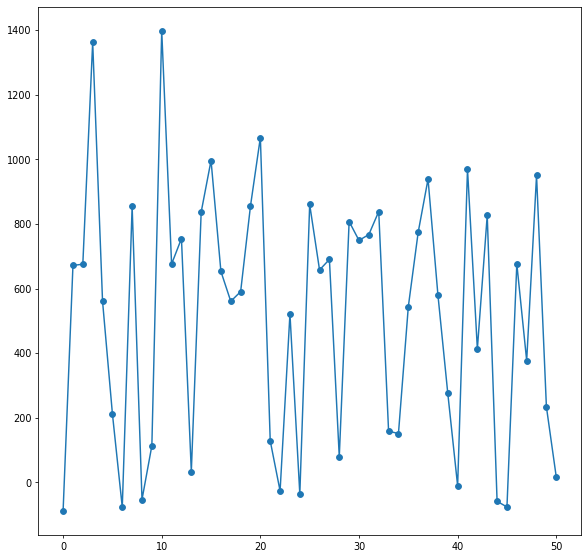

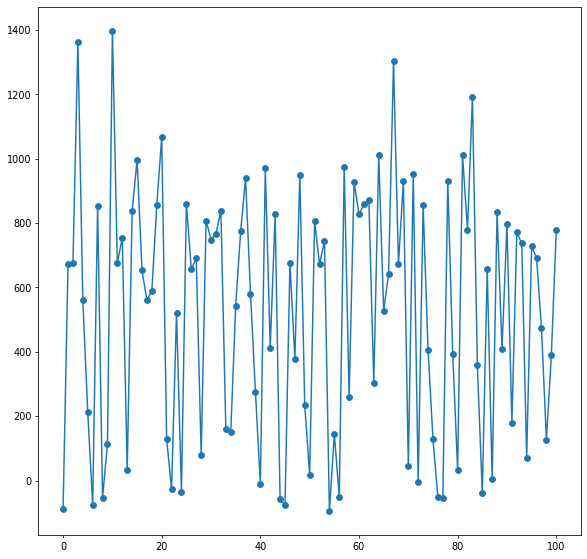

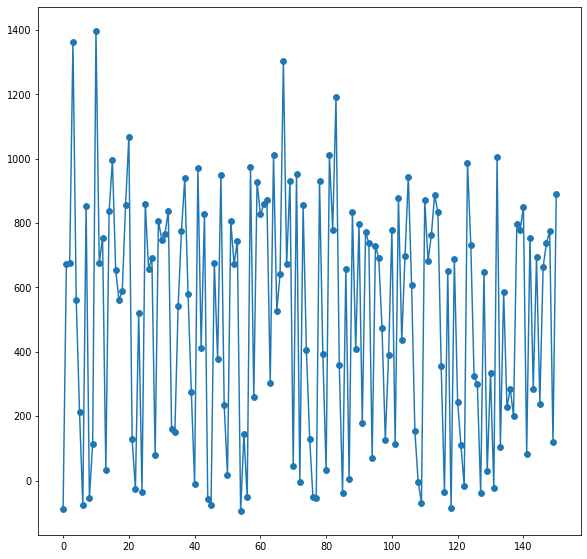

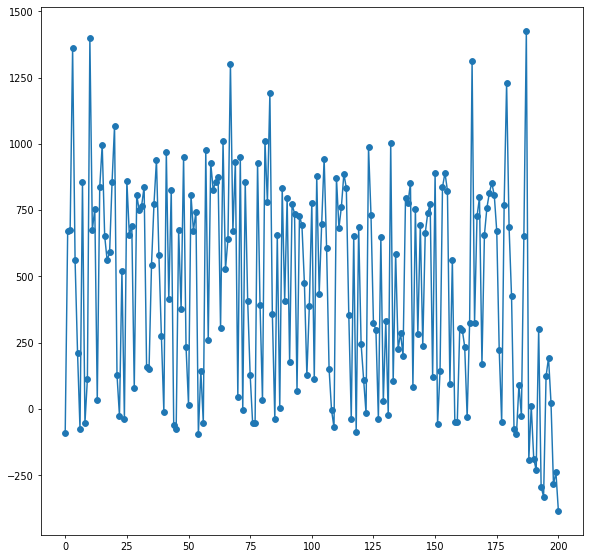

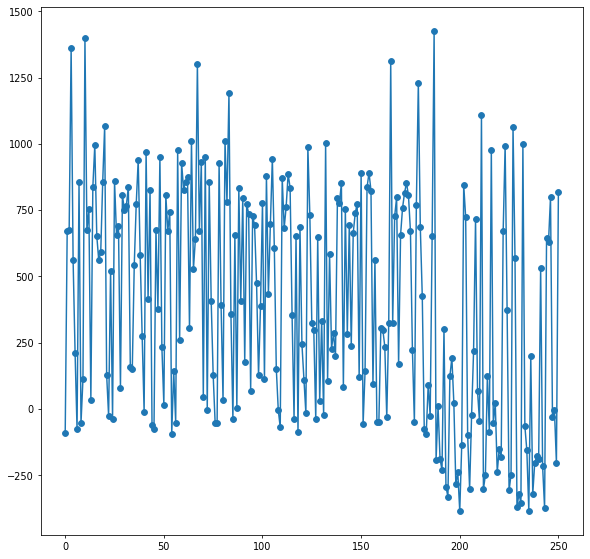

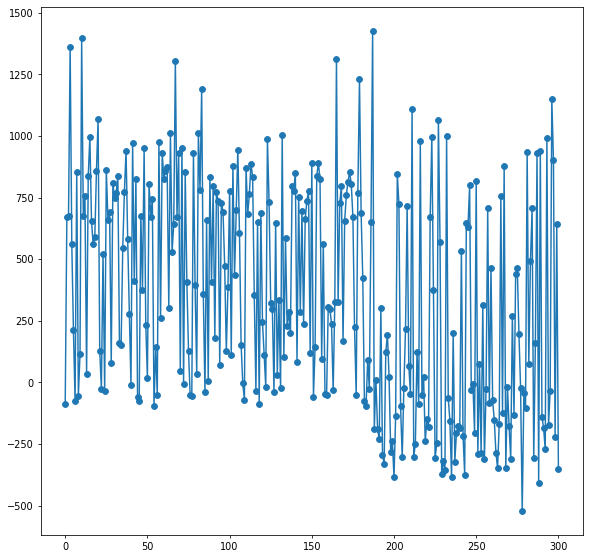

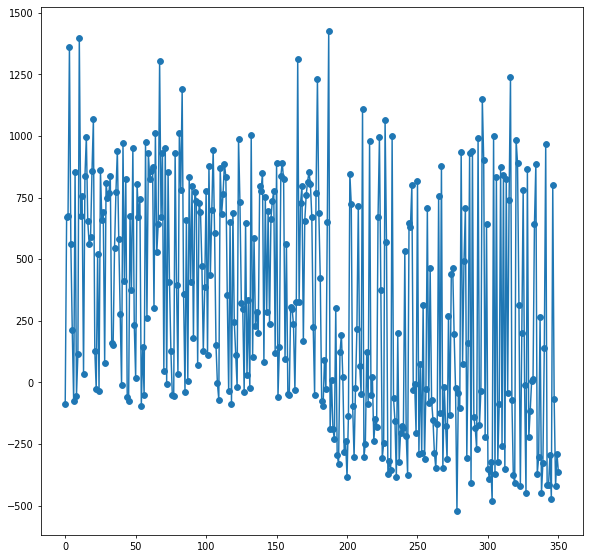

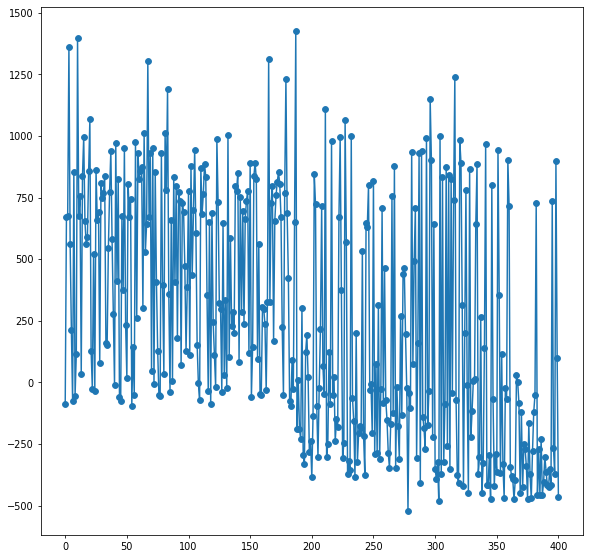

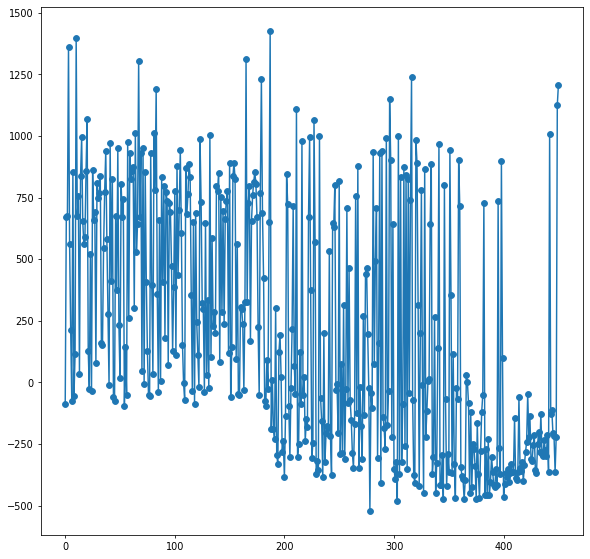

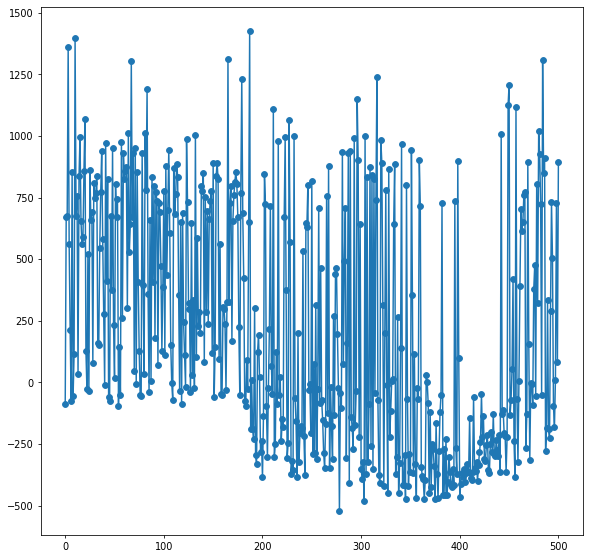

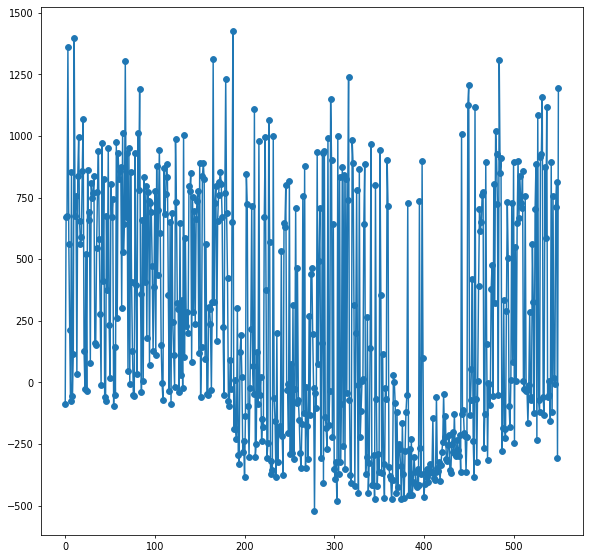

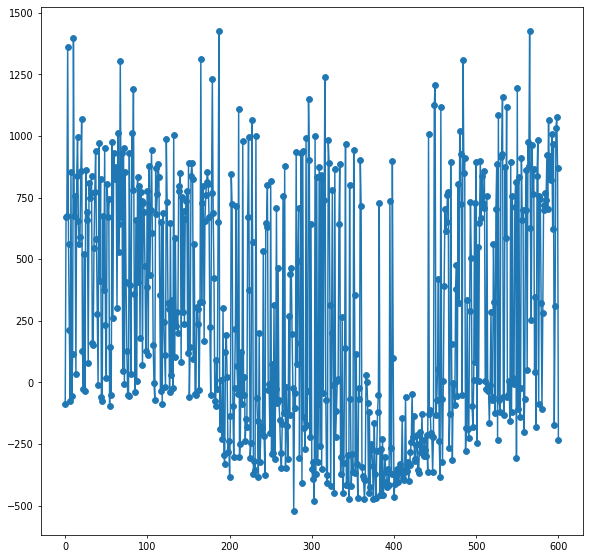

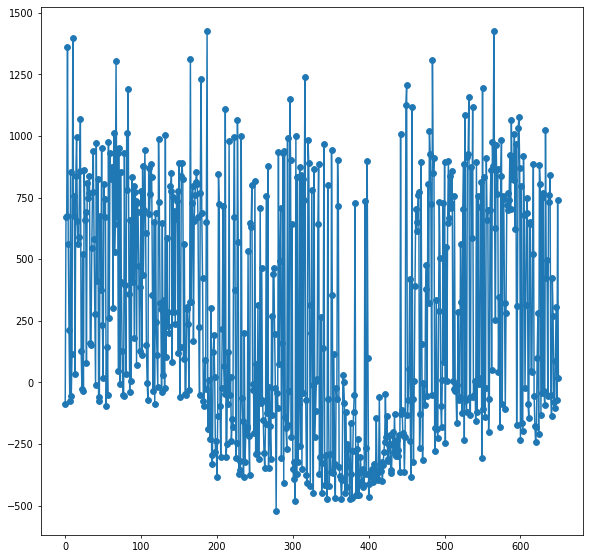

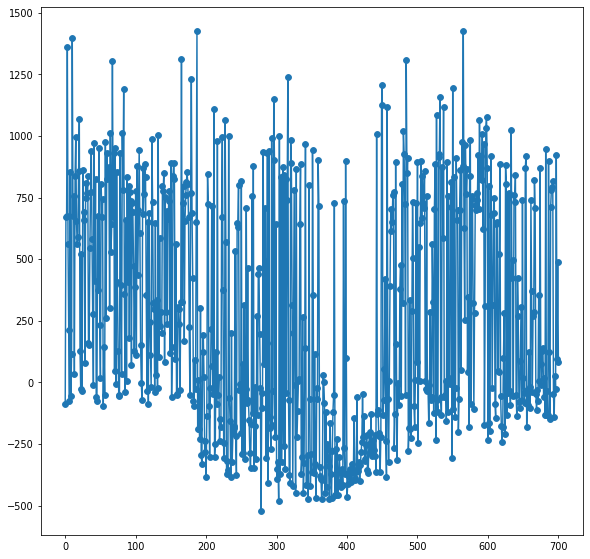

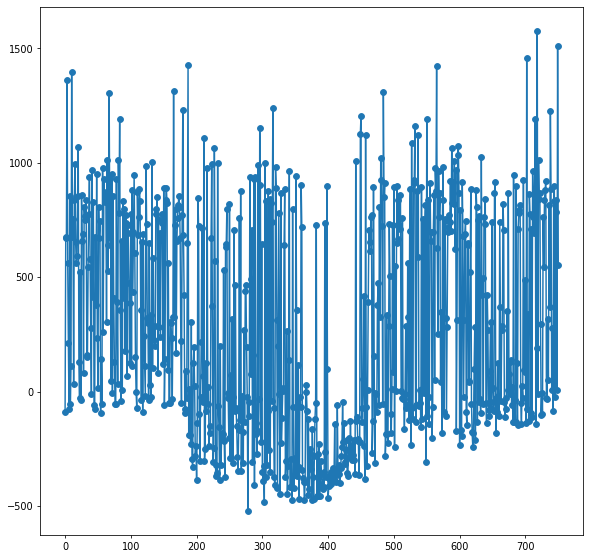

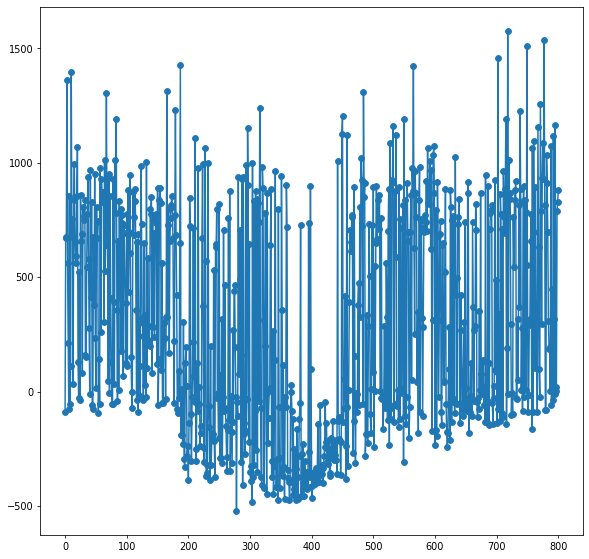

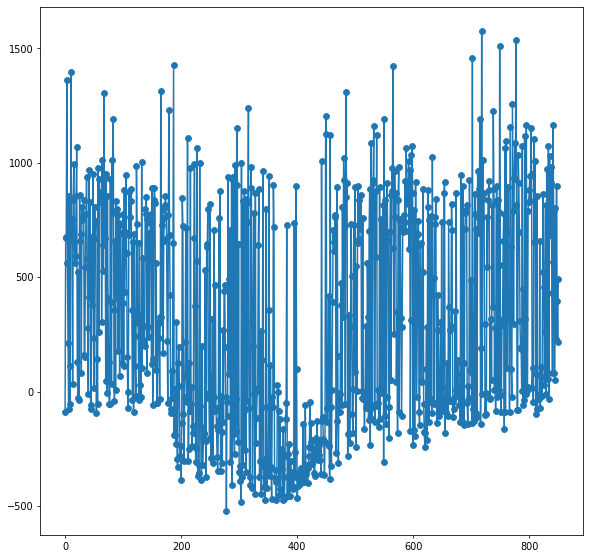

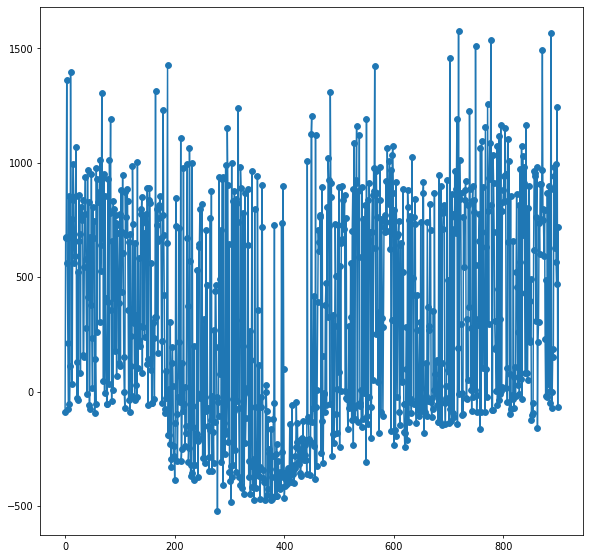

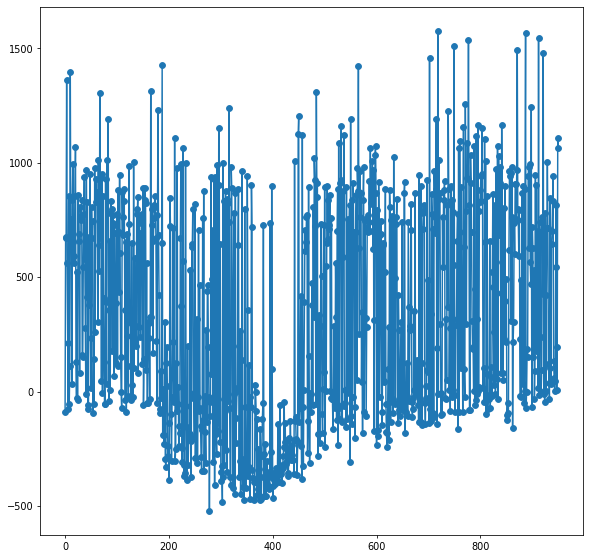

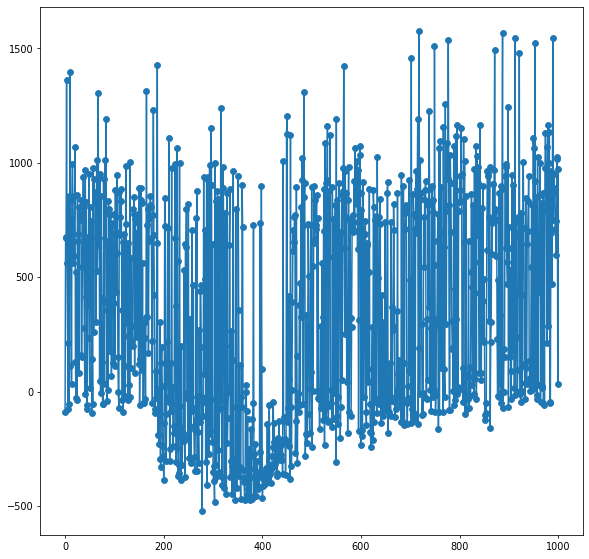

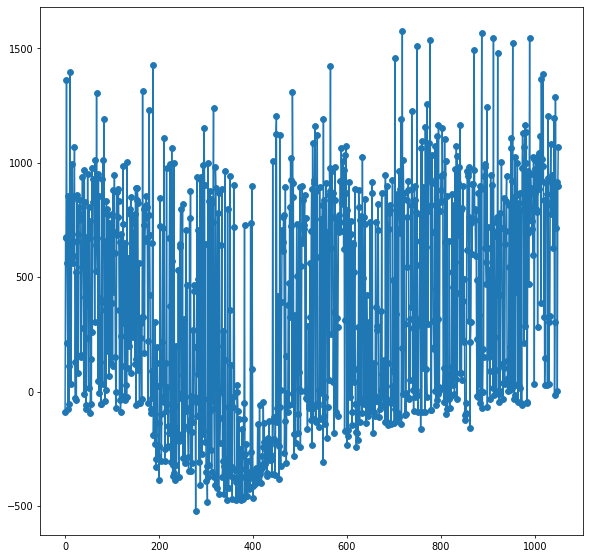

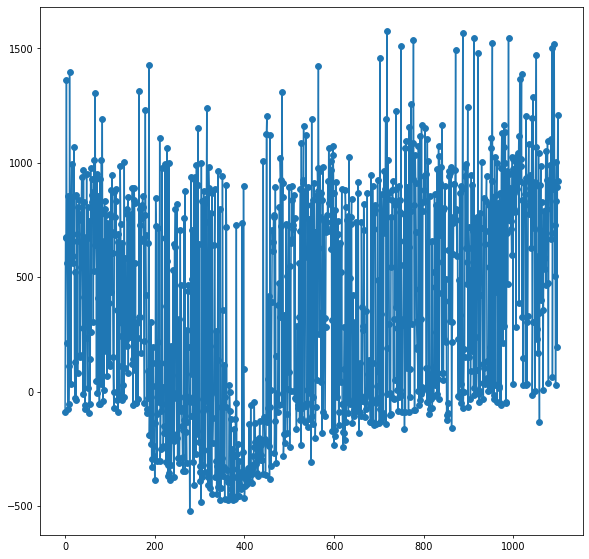

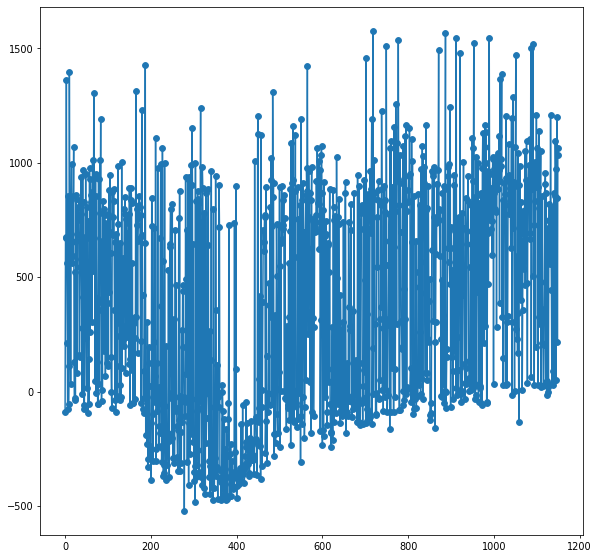

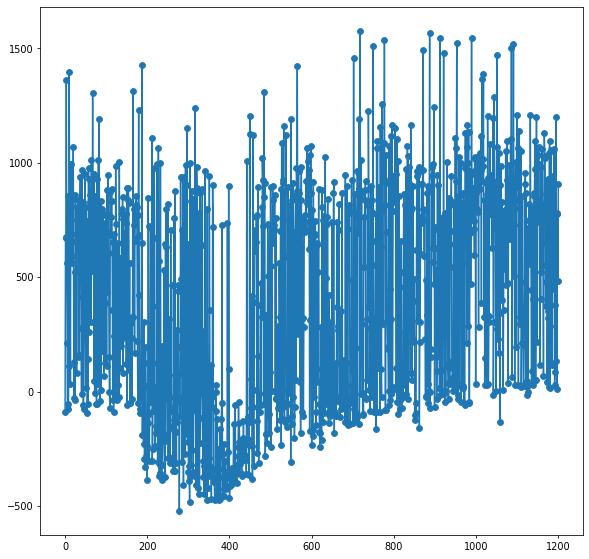

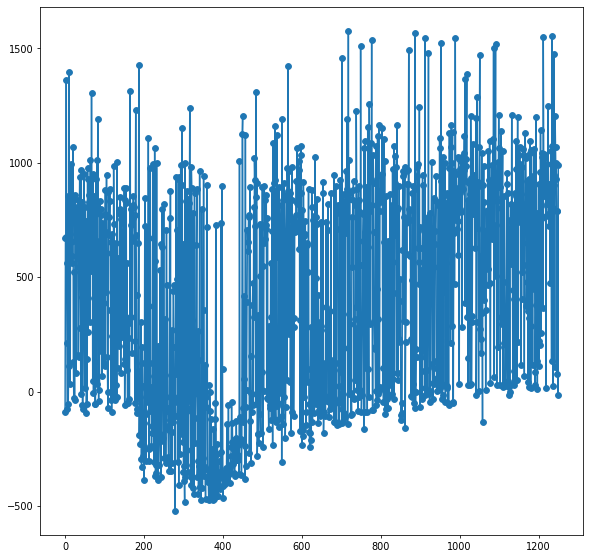

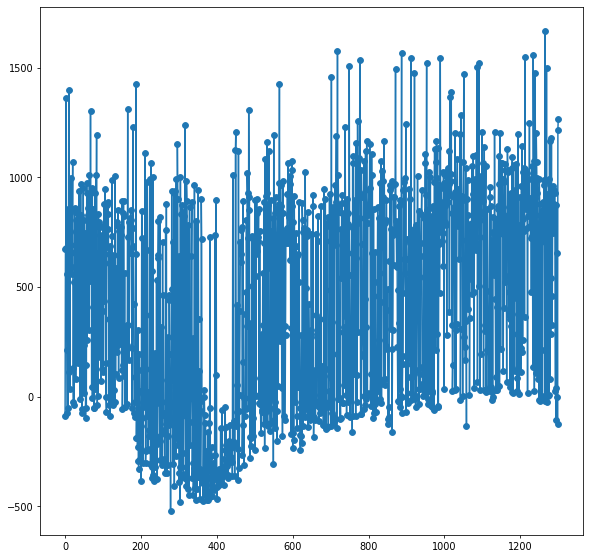

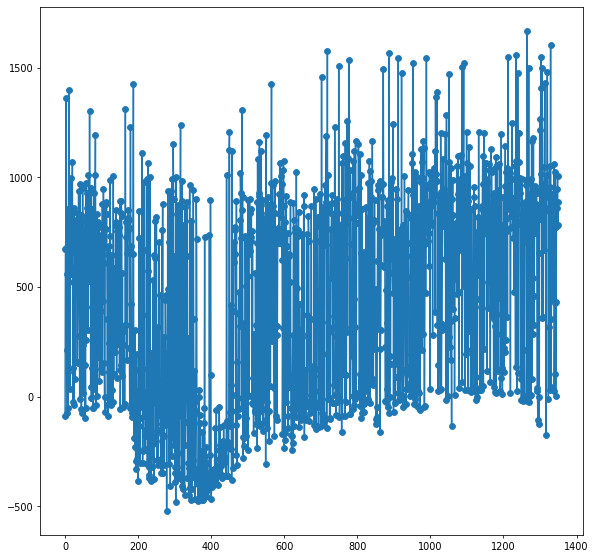

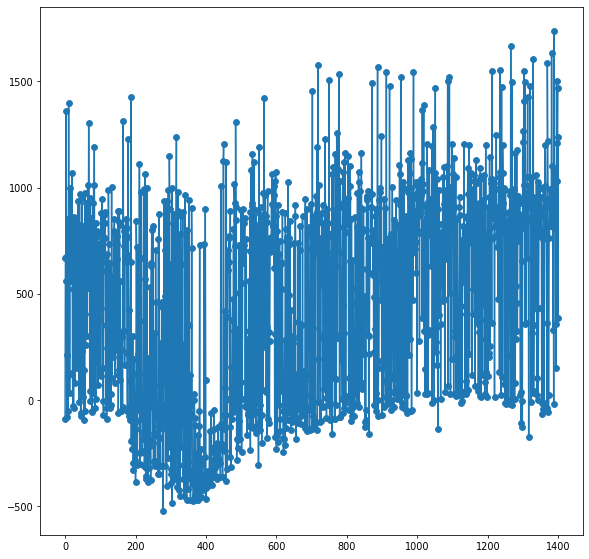

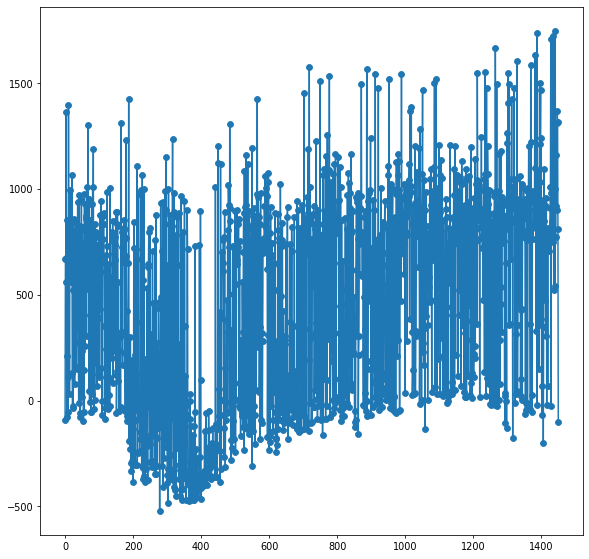

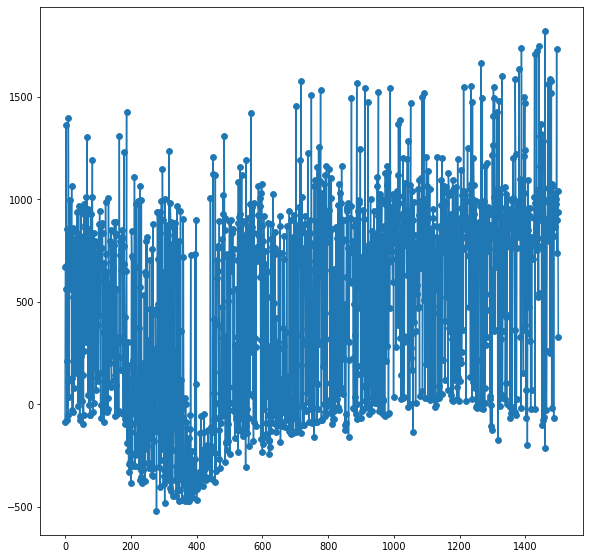

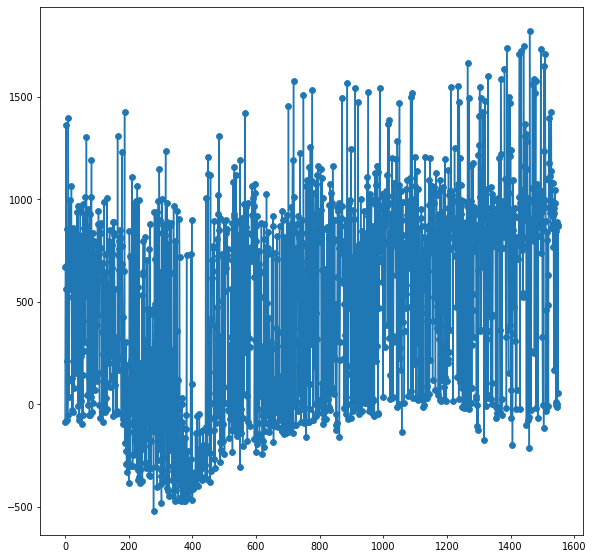

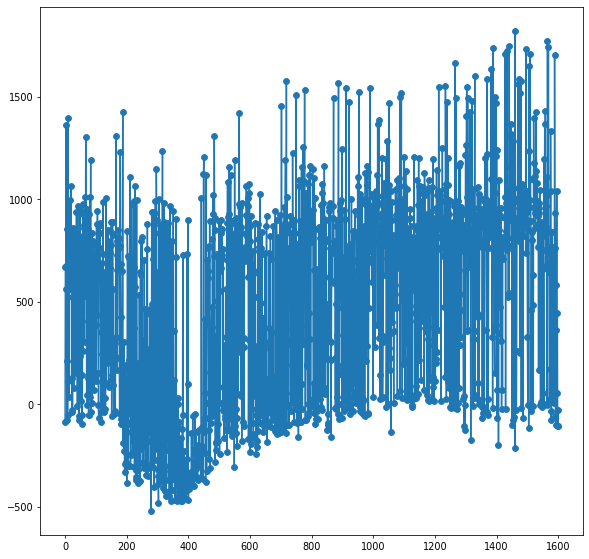

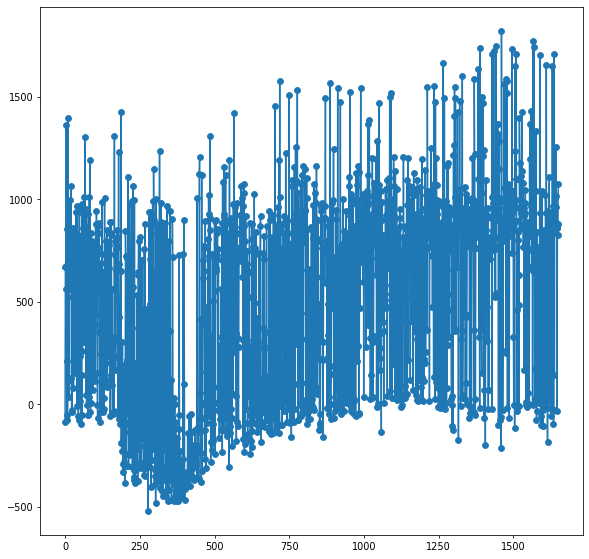

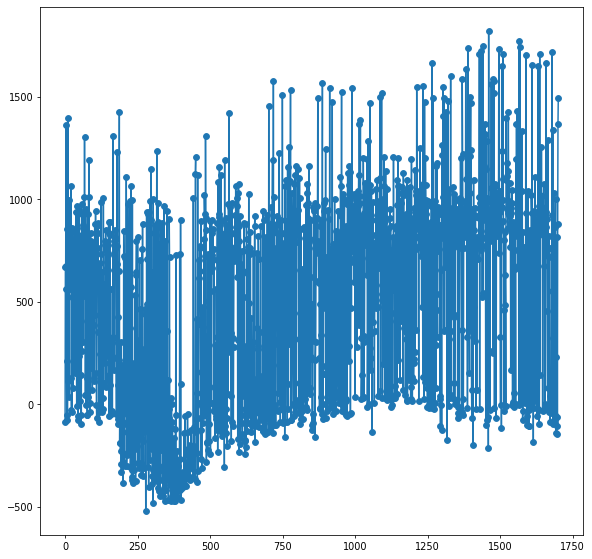

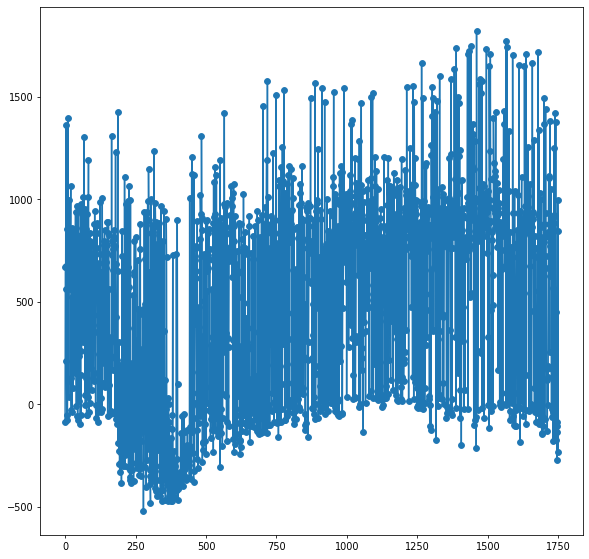

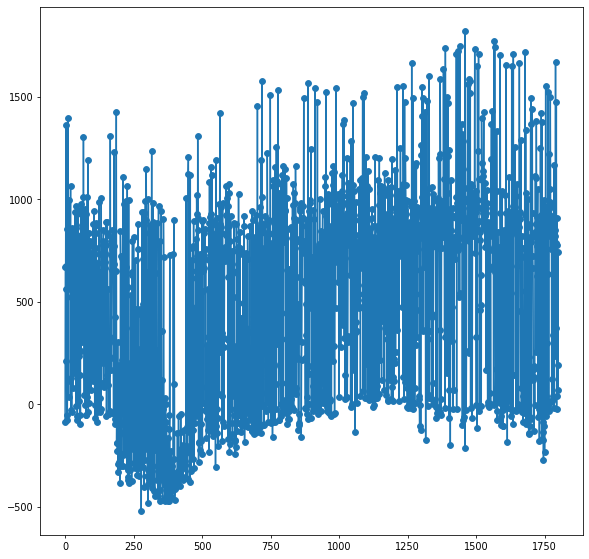

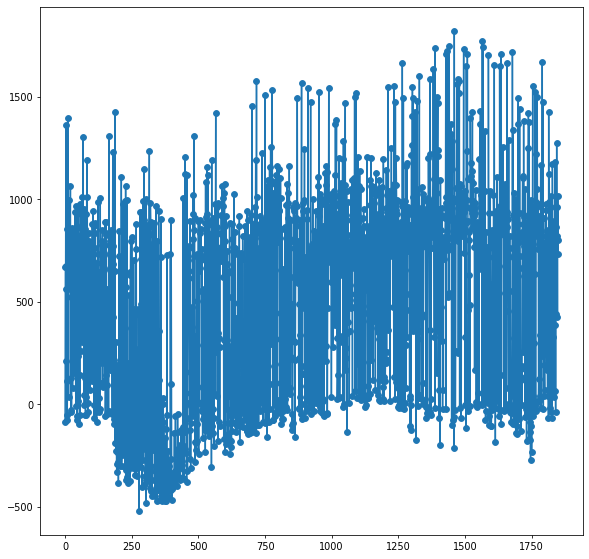

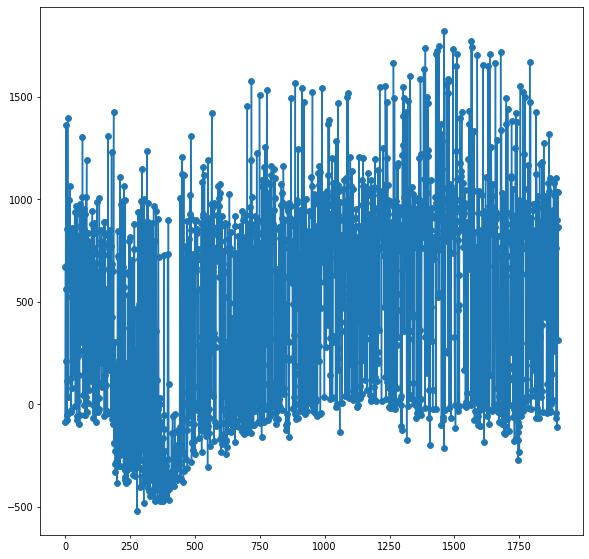

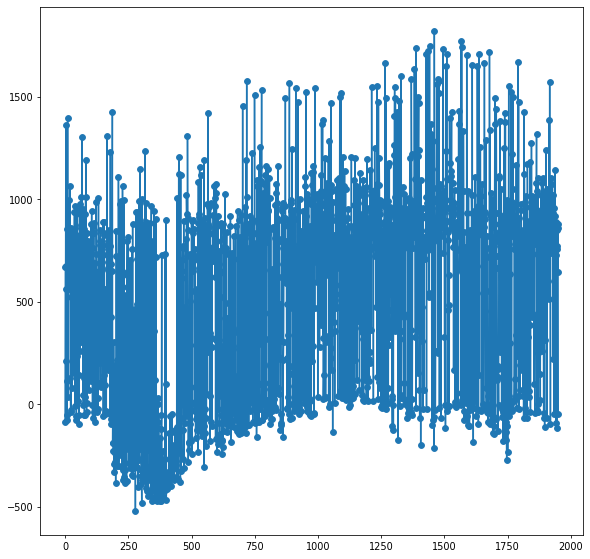

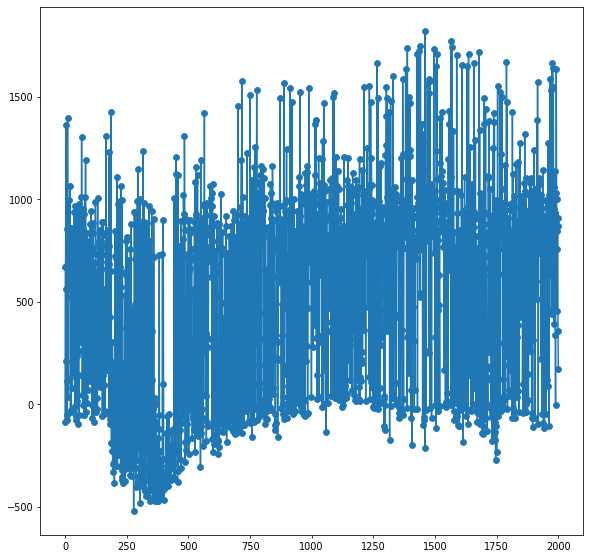

In [7]:
##############################  training  ####################################
env = gym.make(ENV_NAME)
env = env.unwrapped
env.seed(SEED)                                          # 设置Gym的随机数种子
torch.manual_seed(SEED)                                 # 设置pytorch的随机数种子

env.set_env_mode(obs_mode='state', reward_type='dense')

s_dim = env.observation_space.shape[0]                  # 状态空间
a_dim = env.action_space.shape[0]                       # 动作空间
a_bound = 1                                             # 动作取值区间,对称区间，故只取上界
hidden_dim = 512
#lr_a = 0.001
#lr_c = 0.001
ddpg = DDPG(a_dim, s_dim, a_bound, hidden_dim)

if LOAD_MODEL:
    ddpg.load_model()

    
if LOAD_MEM:
    ddpg.load_memory()

if LOAD_PRETRAIN:
    ddpg.load_pretrain()


if LOAD_MODEL or LOAD_MEM:
    var = 0.05

if LOAD_PRETRAIN:
    var = 0.2

list = [1, 2, 7, 8, 9, 11, 14, 18, 33]
#list = [1, 2, 7, 8, 9]
t1 = time.time()                                        # 开始时间

for i in range(MAX_EPISODES):
    LEVEL = random.choice(list)
    s = env.reset(level = LEVEL)
    #s = env.reset(level = int(random.choice([1,2,7,8,9])))
    ep_reward = 0
    
    #if i > 500:
        
     #   if lr_a >= 0.000001:
      #      lr_a = lr_a - 0.0000001
       # if lr_c >= 0.000001:
        #    lr_c = lr_c - 0.0000001
    
    for j in range(MAX_EP_STEPS):
        if RENDER:
            env.render('human')

        # Add exploration noise
        a = ddpg.choose_action(s)

        a = np.clip(np.random.normal(a, var), -1, 1)    # add randomness to action selection for exploration

        s_, r, done, info = env.step(a)
        
        info_ = info.get('eval_info')
        
        if info_.get('success'):
            print('SUCCESS')
            ddpg.Record_success(i)
            r += 100 #+200
        
        r += 10
        r = r * 200
        r+= 200
        r += info.get('qpos') * 4000
        #print(r)
        ddpg.store_transition(s, a, r, s_)         # 为什么要对reward归一化
    
        
        if ddpg.pointer > ddpg.memory_capacity or LOAD_MEM:         # 经验池已满
            if var > var_low_bound:
                var *= .9995                            # 学习阶段逐渐降低动作随机性decay the action randomness
            ddpg.learn()                                # 开始学习

        s = s_
        ep_reward += r
        if j == MAX_EP_STEPS -1 or done:
            print('Episode:', i, ' Reward: %i' % int(ep_reward/j), 'Explore: %.2f' % var, )
            
            ddpg.store_reward(ep_reward/j)
            
            #if ddpg.pointer > ddpg.memory_capacity and done:
                #RENDER = True
            if (i % CHECK_POINT_EPI) == 0 and i != 0:
                ddpg.save('level_9_4000+2000_60/' + str(i) + 'epi')
            
            break
               
print('Running time: ', time.time() - t1)

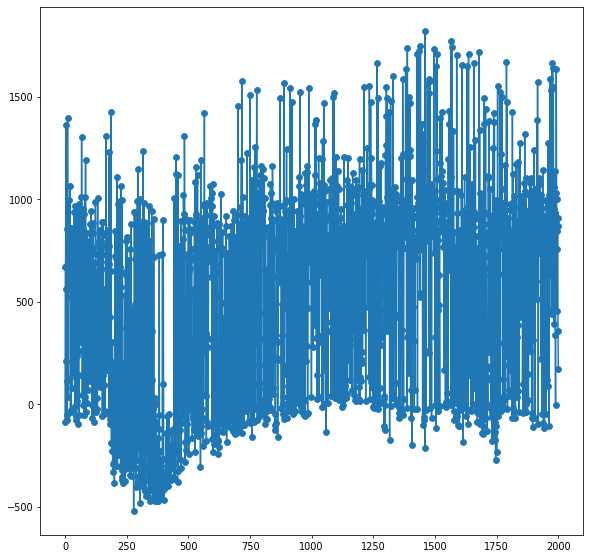

In [9]:
ddpg.save('carbinet_SELF_level_9_4000+2000EPS_60_50')

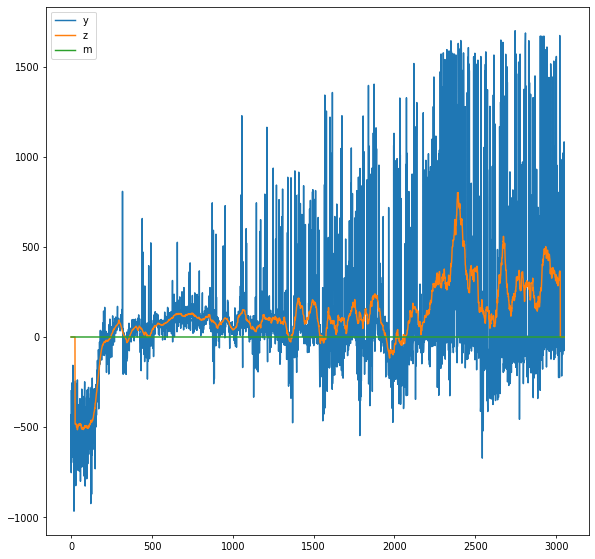

maximum success rate:  0.0
maximum mean rewards:  800.5924504191495


In [8]:
data = pd.read_csv('./DPG model/level12789_check_point_final/3050epi/Rewards.csv')
y = np.array(data).squeeze()
x = range(y.shape[0])

size = 50

z = np.zeros(len(y))
m = np.zeros(len(y))

#for i in range(len(y)):
#    if y[i] >= 10:
#        y[i] = 0
        
for i in range(len(y)):
    
    if i > (size/2 -1) and i < (len(y) - size/2):  
        for j in range(size):
            z[i] += y[i + j - int(size/2)]  #平均reward
            
            if(y[i + j - int(size/2)] == 0):
                m[i] += 1                  #success rate
            
                                   
            
        z[i] = z[i] / size
        m[i] = m[i]
        

    
    
plt.figure(figsize=(10, 10), dpi=70)

plt.plot(x, y)
plt.plot(x, z)
plt.plot(x, m)

plt.legend(['y','z','m'])
plt.show()

print('maximum success rate: ', max(m)/50)
print('maximum mean rewards: ', max(z))

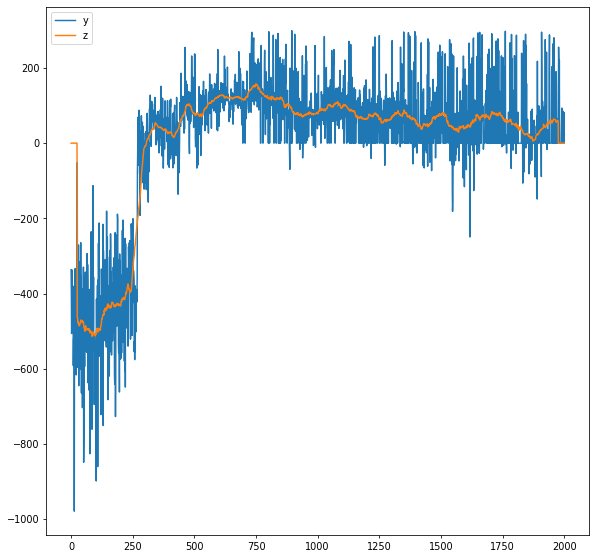

maximum mean rewards:  750


In [15]:
data = pd.read_csv('./DPG model/level_5_4000+2000_60/2000epi/Rewards.csv')
y = np.array(data).squeeze()
x = range(y.shape[0])
size = 50
z = np.zeros(len(y))
for i in range(len(y)):
    if y[i] >= 300:
        y[i] = 0  
for i in range(len(y)):
    if i > (size/2 -1) and i < (len(y) - size/2):  
        for j in range(size):
            z[i] += y[i + j - int(size/2)]  #平均reward        
    z[i] = z[i]/size
plt.figure(figsize=(10, 10), dpi=70)
plt.plot(x, y)
plt.plot(x, z)
plt.legend(['y','z'])
plt.show()
print('maximum mean rewards: ', np.argmax(z))

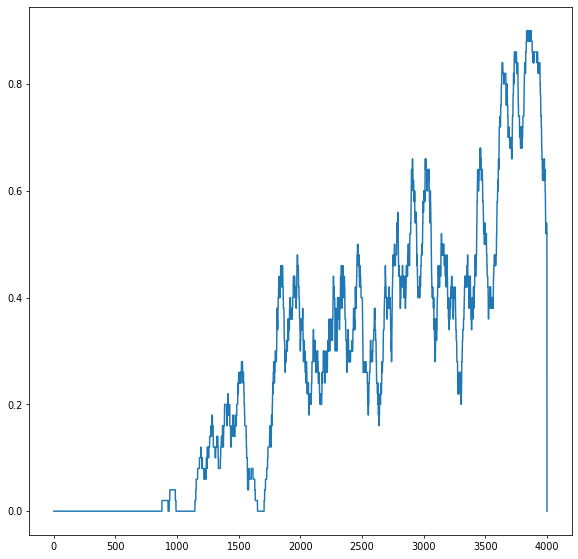

0.9
3835


In [17]:
data = pd.read_csv('./DPG model/level_5_4000+2000_60/4000epi/Success_record.csv')
y = np.array(data).squeeze()
x = range(y.shape[0])
m = np.zeros(y.shape[0])

for i in range(50,4000):
    for j in range(50):
        if y[i-50+j] == 1:
            m[i] += 1
    m[i] = m[i] / 50   
    
plt.figure(figsize=(10, 10), dpi=70)
plt.plot(x, m)
plt.show()
print(max(m))#最大值
print(np.argmax(m))#最大值所在位置